# Loading MNIST data

In [50]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [51]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plotImages(images, labels, title):

    total = len(images)
    row = 1 + (total - 1) // 8
    plt.figure(figsize = (10, 5))

    for i in range(total):
        plt.subplot(row, 8, i + 1)
        plt.imshow(images[i], cmap = 'gray')
        plt.title(np.argmax(labels[i]))
        plt.axis('off')
    
    plt.suptitle(title)
    
    plt.show



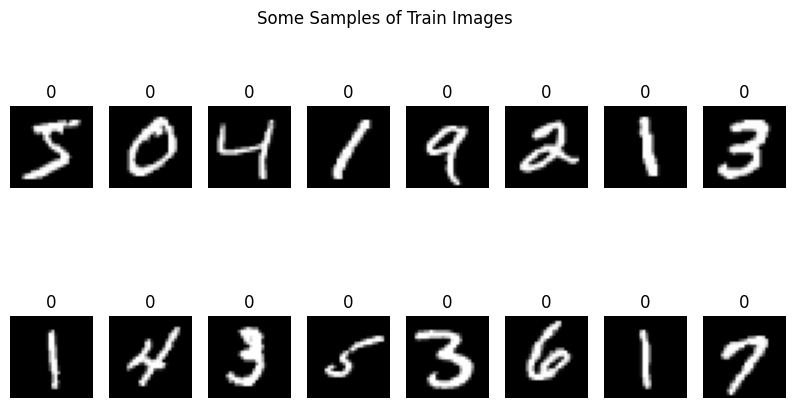

In [55]:
images_to_display = train_images[:16]
labels_to_display = train_labels[:16]

plotImages(images_to_display, labels_to_display, 'Some Samples of Train Images')

# Preprocessing Images

In [5]:
from tensorflow.keras.utils import to_categorical 

x_train = train_images.astype('float32') / 255.0
x_test = test_images.astype('float32') / 255.0

y_train = to_categorical(train_labels, num_classes = 10)
y_test = to_categorical(test_labels, num_classes = 10)

x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


# Split Images

In [6]:
ratio = 0.1
total_valid = int(ratio * len(x_train))

x_valid = x_train[:total_valid]
y_valid = y_train[:total_valid]


x_train = x_train[total_valid:]
y_train = y_train[total_valid:]


print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(54000, 28, 28, 1) (54000, 10) (6000, 28, 28, 1) (6000, 10)


# Function for Augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def perform_augmentation(images, labels, numper_per_sample):

    datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.3,
        zoom_range = 0.2,
        horizontal_flip = True,
    )

    augmented_images = []
    augmented_labels = []

    for i in range(len(images)):
        image = np.expand_dims(images[i], axis = 0) # For adding batch dimension
        label = labels[i]

        aug_itr = datagen.flow(image, batch_size = 1)

        for _ in range(numper_per_sample):
            aug_image = next(aug_itr)[0]
            augmented_images.append(aug_image)
            augmented_labels.append(label)
        
    
    return np.array(augmented_images), np.array(augmented_labels)

### Perfroming Augmentation

In [8]:
augmented_x_train, augmented_y_train = perform_augmentation(x_train, y_train, 1)

In [9]:
print(augmented_x_train.shape, augmented_y_train.shape)

(54000, 28, 28, 1) (54000, 10)


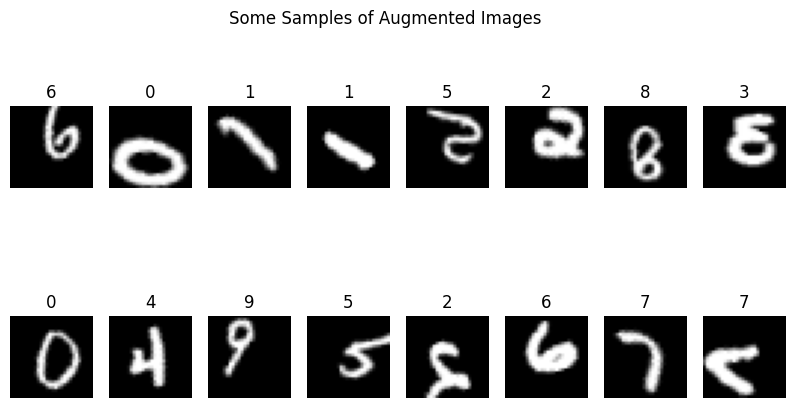

In [56]:
plotImages(augmented_x_train[:16], augmented_y_train, 'Some Samples of Augmented Images')

In [10]:
augmented_x_train = np.concatenate((augmented_x_train, x_train))
augmented_y_train = np.concatenate((augmented_y_train, y_train))

print(augmented_x_train.shape, augmented_y_train.shape)

(108000, 28, 28, 1) (108000, 10)


## Function to generate a model

In [11]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

def generate_cnn(input_shape, output):

    inputs = Input(input_shape)

    x = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same')(inputs)
    x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)

    x = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)

    x = Flatten()(x)
    x = Dense(64, activation = 'relu')(x)

    outputs = Dense(output, activation = 'softmax')(x)

    model = Model(inputs, outputs, name = 'CNN_Model')

    return model

### Function for Transfer Learning

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def generate_cnn_with_vgg16(input_shape, output):

    # Load the VGG16 model pre-trained on ImageNet, excluding the top fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False)
    
    # Modify the first layer to accept grayscale inputs (28x28x1)
    inputs = Input(shape=input_shape)
    
    # Change input from grayscale to RGB by repeating the grayscale channel 3 times
    x = tf.keras.layers.Conv2D(3, (3, 3), padding="same")(inputs)  # convert 1 channel to 3 channels
    
    # Pass the 3-channel image to the VGG16 model
    x = base_model(x)

    # Add custom layers on top of the VGG16 base model
    x = Flatten()(x)  # Flatten the output of VGG16
    x = Dense(64, activation='relu')(x)  # Add a fully connected layer with 64 units
    outputs = Dense(output, activation='softmax')(x)  # Output layer for classification

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='VGG16_Grayscale_Model')

    # Freeze all layers of the base model, since they are pre-trained on ImageNet
    for layer in base_model.layers:
        layer.trainable = False

    return model


## summery and compile the model

In [12]:
input_shape = x_train[0].shape
print(input_shape)

model1 = generate_cnn(input_shape, 10)
model1.summary()


model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

(28, 28, 1)


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,234 (860.29 KB)

 Trainable params: 220,234 (860.29 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
input_shape = x_train[0].shape
print(input_shape)

model_trans = generate_cnn_with_vgg16(input_shape, 10)
model_trans.summary()


(28, 28, 1)


Model: "VGG16_Grayscale_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 0, 0, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,432 (56.13 MB)

 Trainable params: 744 (2.91 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
model1_history = model1.fit(x_train, y_train, epochs=10, validation_data = (x_valid, y_valid), batch_size = 64)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9903 - loss: 0.0316 - val_accuracy: 0.9812 - val_loss: 0.0564
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9926 - loss: 0.0225 - val_accuracy: 0.9883 - val_loss: 0.0416
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9950 - loss: 0.0146 - val_accuracy: 0.9880 - val_loss: 0.0438
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9961 - loss: 0.0127 - val_accuracy: 0.9883 - val_loss: 0.0415
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9966 - loss: 0.0104 - val_accuracy: 0.9877 - val_loss: 0.0538
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9975 - loss: 0.0079 - val_accuracy: 0.9887 - val_loss: 0.0430
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9978 - loss: 0.0059 - val_accuracy: 0.9830 - val_loss: 0.0624
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9977 - loss: 0

In [21]:
loss, acc = model1.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9878 - loss: 0.0611


In [33]:
training_loss = model1_history.history['loss']
training_acc = model1_history.history['accuracy']

valid_loss = model1_history.history['val_loss']
valid_acc = model1_history.history['val_accuracy']

epochs = range(1, len(training_loss) + 1)
acc = np.arange(0, 1.1, 0.2)
print(epochs)
print(acc)

range(1, 11)
[0.  0.2 0.4 0.6 0.8 1. ]


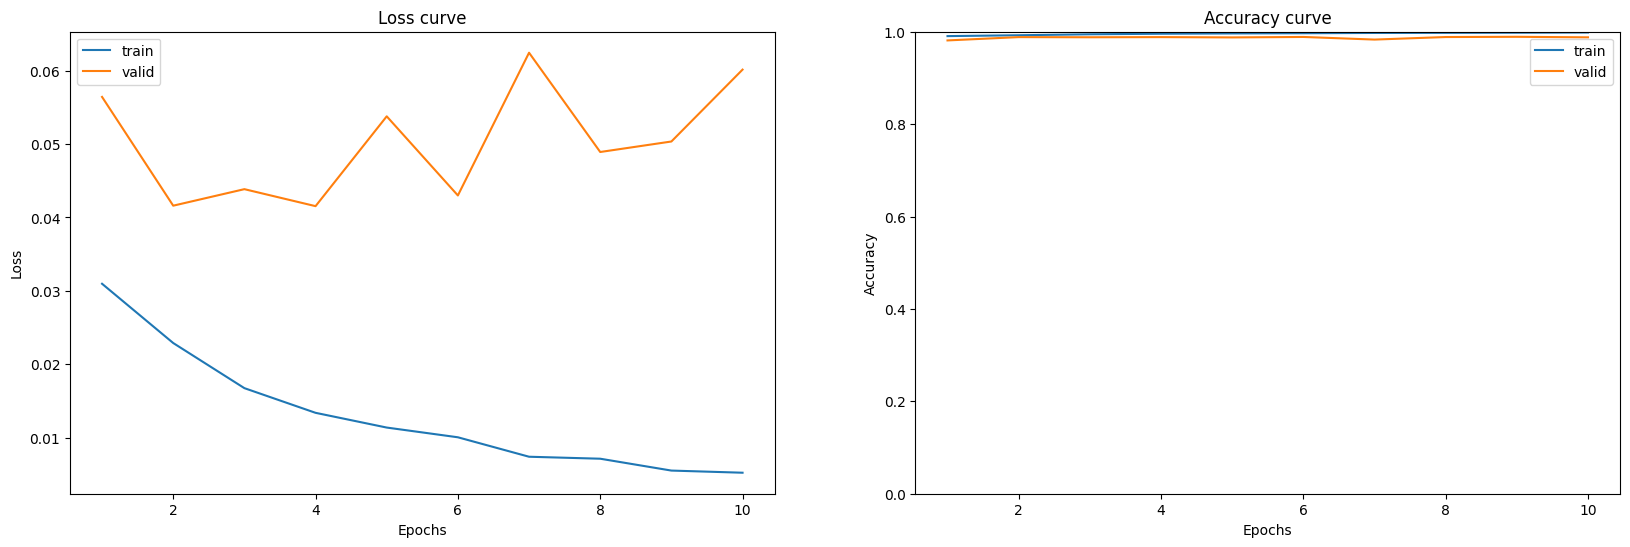

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 6))

plt.subplot(1,2,1)
plt.plot(epochs, training_loss, label = 'train')
plt.plot(epochs, valid_loss, label = 'valid')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, training_acc, label = 'train')
plt.plot(epochs, valid_acc, label = 'valid')
plt.title('Accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(acc)
plt.legend()

plt.show()